<a href="https://colab.research.google.com/github/hwangho-kim/LLM-AD/blob/master/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94_%EB%B0%8F_SHAP_%EA%B8%B0%EB%B0%98_FDC_%EB%B6%84%EC%84%9D_%EB%AA%A8%EB%8D%B8_(%ED%94%BC%EC%B2%98_%EA%B0%95%ED%99%94).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

500개 웨이퍼에 대한 샘플 데이터 생성을 시작합니다...
샘플 데이터 생성이 완료되었습니다.

[생성된 MES 데이터 샘플 (상위 5개)]
   wafer_id equipment_id recipe_id anomaly_type  final_yield
0  WAF_0001     Etcher_B  Recipe_1       Normal            1
1  WAF_0002     Etcher_C  Recipe_1       Normal            1
2  WAF_0003     Etcher_B  Recipe_1       Normal            1
3  WAF_0004     Etcher_C  Recipe_2       Normal            1
4  WAF_0005     Etcher_A  Recipe_1       Normal            1

강화된 시계열 특징 공학을 시작합니다...
특징 추출이 완료되었습니다.
동적/정적 데이터 통합이 완료되었습니다.

[최종 통합 데이터셋 샘플 (상위 5개)]
   wafer_id equipment_id recipe_id anomaly_type  final_yield  pressure_mean  \
0  WAF_0001     Etcher_B  Recipe_1       Normal            1      99.929510   
1  WAF_0002     Etcher_C  Recipe_1       Normal            1      99.956196   
2  WAF_0003     Etcher_B  Recipe_1       Normal            1     100.127083   
3  WAF_0004     Etcher_C  Recipe_2       Normal            1     100.000127   
4  WAF_0005     Etcher_A  Recipe_1       Normal            1      99.94

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 22)             │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 45)             │         1,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,696 (10.53 KB)

 Trainable params: 2,696 (10.53 KB)

 Non-trainable params: 0 (0.00 B)


오토인코더 모델 학습을 시작합니다...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2655 - val_loss: 0.2489
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2386 - val_loss: 0.1956
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1810 - val_loss: 0.1422
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1357 - val_loss: 0.1182
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1145 - val_loss: 0.1074
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1071 - val_loss: 0.1004
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1019 - val_loss: 0.0969
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0956 - val_loss: 0.0957
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0957 - val_loss: 0.0950
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0955 - val_loss: 0.0946
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0946 - val_loss: 0.0942
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1

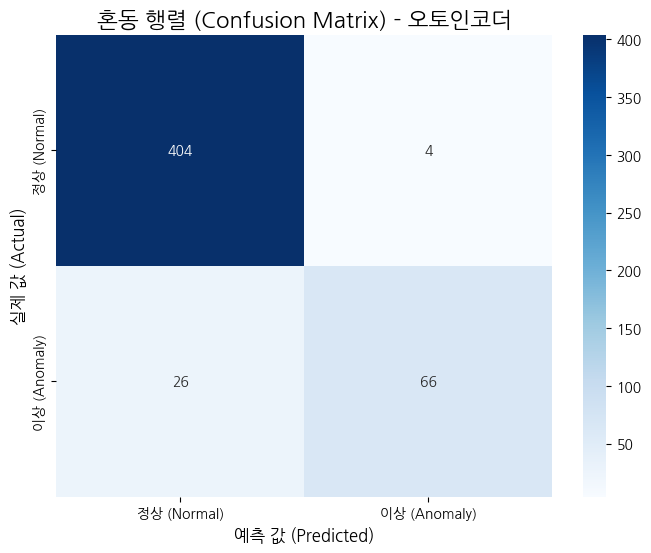


SHAP 분석을 시작합니다 (상위 5개 이상 샘플 대상)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6682/6682 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6682/6682 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6682/6682 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6682/6682 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6682/6682 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

각 이상 샘플에 대한 SHAP Force Plot:
(아래 그래프는 각 특징이 이상 점수를 높이는 방향(빨강) 또는 낮추는 방향(파랑)으로 얼마나 기여했는지 보여줍니다.)


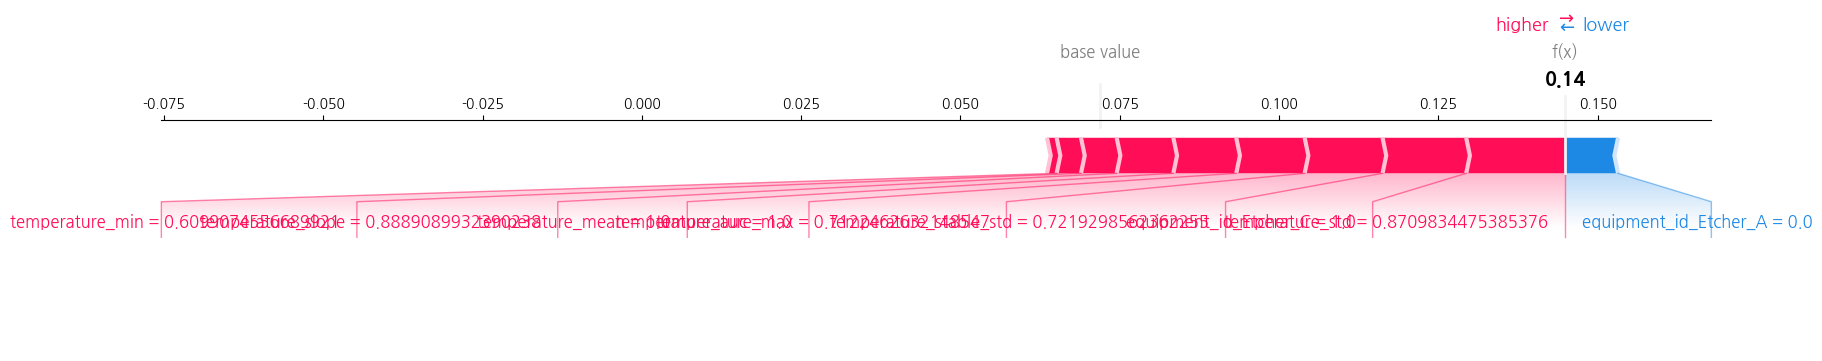

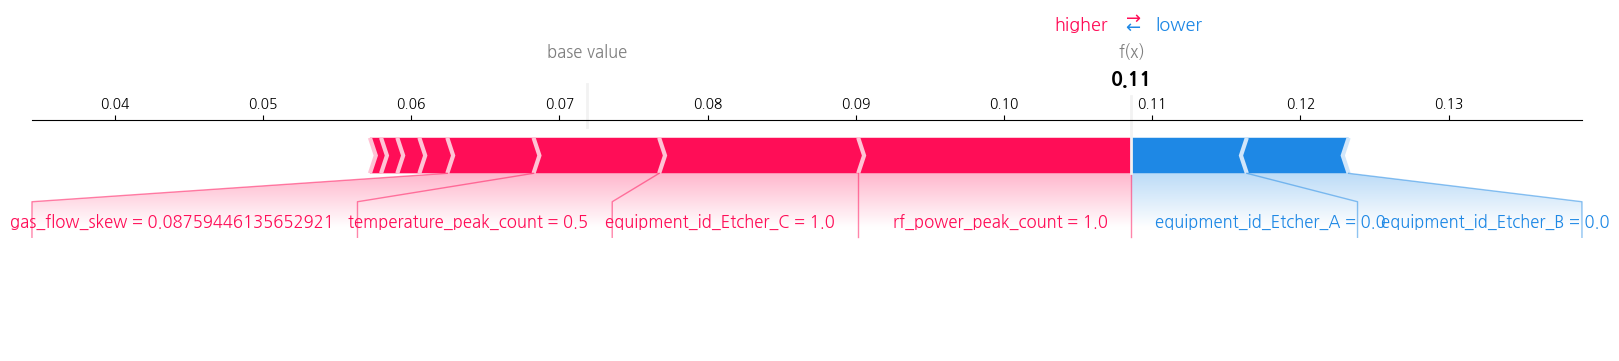

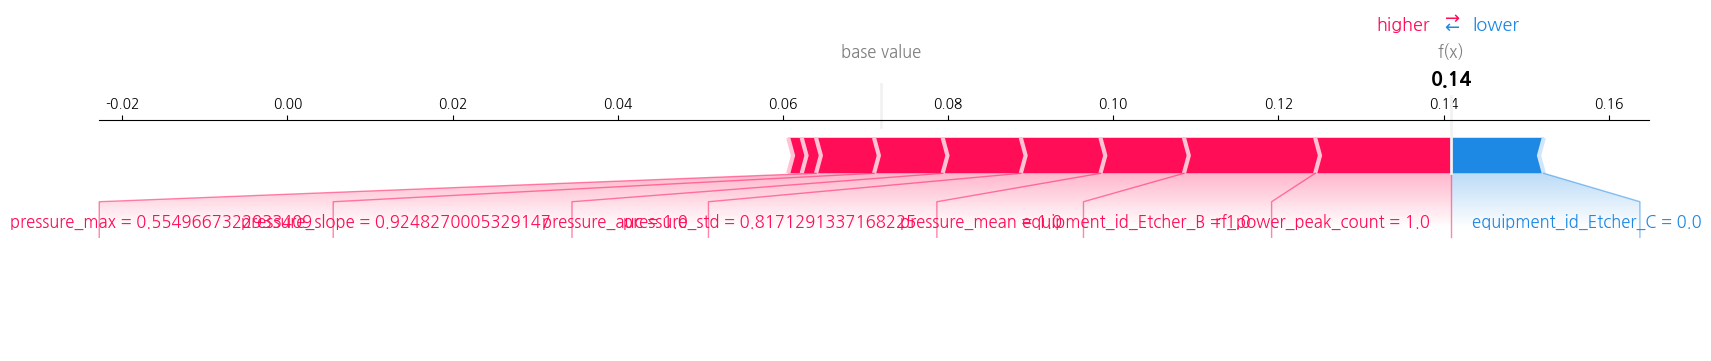

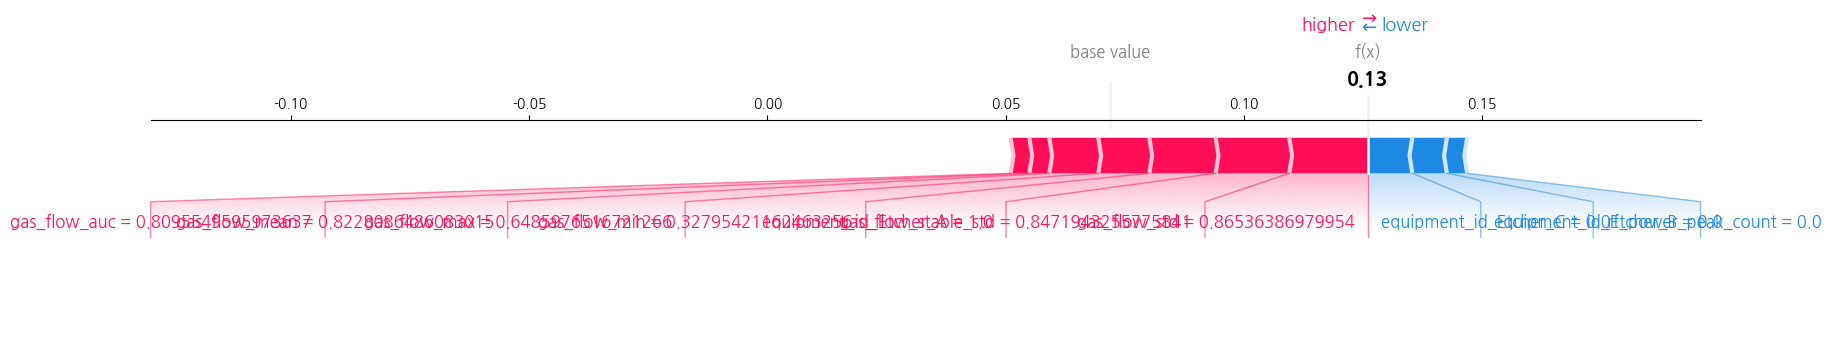

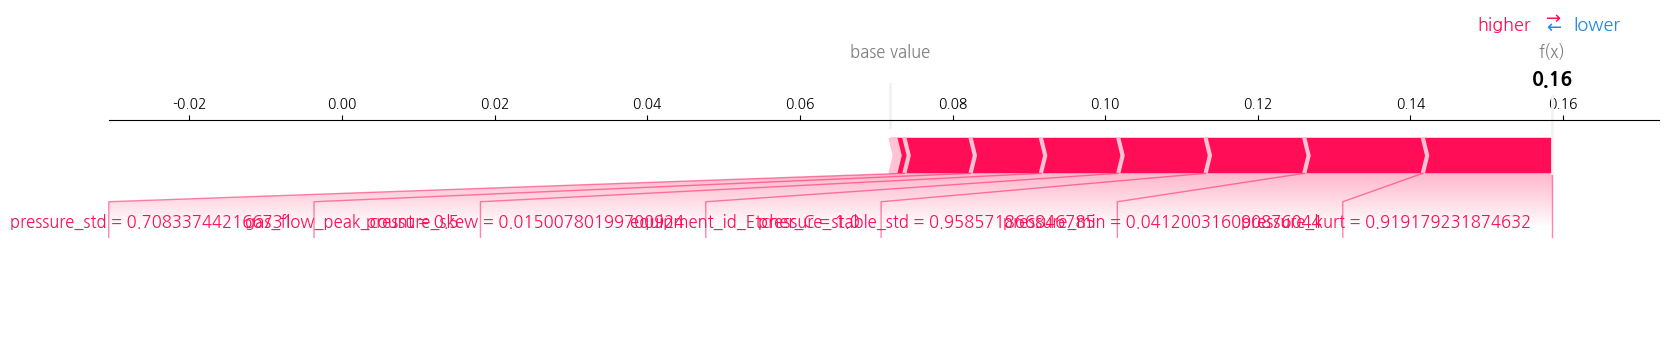


전체 이상 샘플에 대한 SHAP Summary Plot:
(이 그래프는 어떤 특징이 전반적으로 이상 탐지에 큰 영향을 미치는지 보여줍니다.)
점의 색은 특징의 값(높으면 빨강, 낮으면 파랑)을, x축 위치는 SHAP 값(이상 점수에 대한 기여도)을 의미합니다.


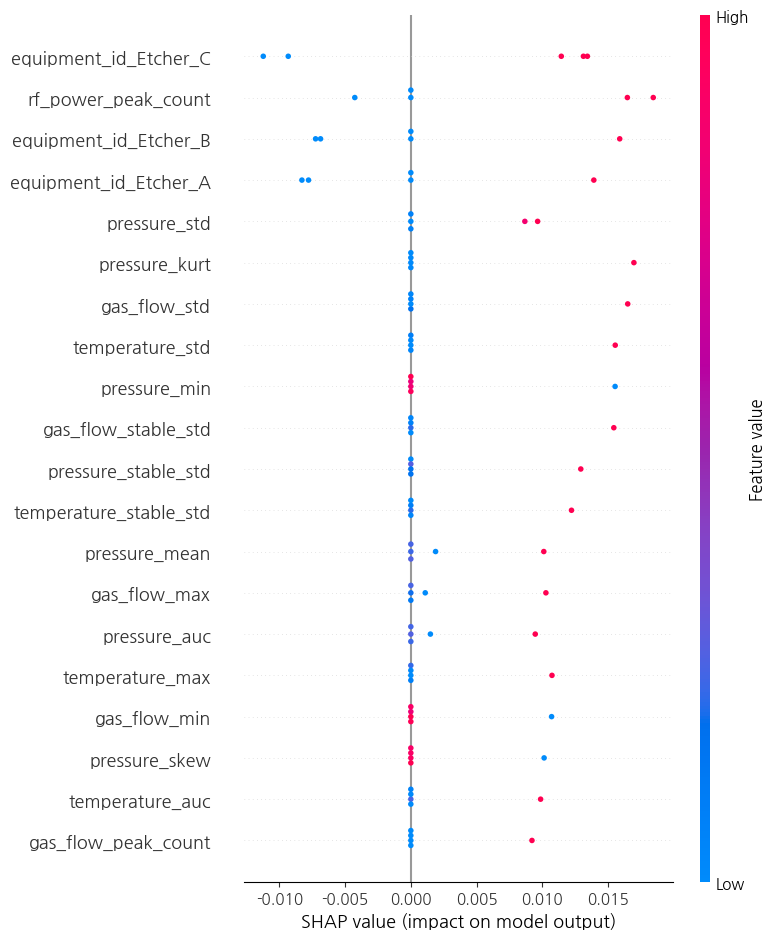

In [3]:
# ==============================================================================
# 패키지 설치 (Package Installation)
# ==============================================================================
# 아래 명령어를 사용하여 이 스크립트 실행에 필요한 주요 라이브러리들을 설치합니다.
# In a command line or terminal, run the following command:
# pip install pandas numpy tensorflow scikit-learn shap matplotlib seaborn koreanize-matplotlib

# ==============================================================================
# 라이브러리 임포트 (Library Imports)
# ==============================================================================
# 데이터 처리, 모델링, 시각화, 설명가능 AI에 필요한 라이브러리들을 임포트합니다.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Matplotlib에서 한글 폰트가 깨지지 않도록 설정
import koreanize_matplotlib

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# ==============================================================================
# 1단계: 샘플 데이터 생성 (Sample Data Generation)
# ==============================================================================
# (이전 코드와 동일)
def generate_wafer_data(num_wafers=500, timesteps=100):
    """
    하나의 공정 스텝에 대한 웨이퍼 데이터를 생성합니다.
    - FDC: 4개의 센서(압력, RF파워, 가스, 온도)에 대한 시계열 데이터
    - MES: 각 웨이퍼의 공정 조건 및 최종 수율 정보
    """
    print(f"{num_wafers}개 웨이퍼에 대한 샘플 데이터 생성을 시작합니다...")
    wafers = []
    for i in range(num_wafers):
        wafer_id = f'WAF_{i+1:04d}'
        equipment_id = np.random.choice(['Etcher_A', 'Etcher_B', 'Etcher_C'])
        recipe_id = np.random.choice(['Recipe_1', 'Recipe_2'])
        wafers.append([wafer_id, equipment_id, recipe_id])
    mes_df = pd.DataFrame(wafers, columns=['wafer_id', 'equipment_id', 'recipe_id'])

    fdc_data = {}
    anomaly_types = []
    final_yields = []
    for i, row in mes_df.iterrows():
        wafer_id = row['wafer_id']
        pressure_mean, rf_power_mean, gas_flow_mean, temp_mean = 100, 500, 200, 80
        pressure = np.random.normal(pressure_mean, 1, timesteps)
        rf_power = np.random.normal(rf_power_mean, 5, timesteps)
        gas_flow = np.random.normal(gas_flow_mean, 2, timesteps)
        temperature = np.random.normal(temp_mean, 0.5, timesteps)
        anomaly_type, final_yield = 'Normal', 1

        if np.random.rand() < 0.2:
            final_yield = 0
            anomaly_choice = np.random.choice(['Spike', 'Variance', 'Drift'])
            anomaly_type = anomaly_choice
            if anomaly_choice == 'Spike':
                spike_sensor = np.random.choice(['pressure', 'rf_power'])
                spike_idx = np.random.randint(20, 80)
                if spike_sensor == 'pressure': pressure[spike_idx] += pressure_mean * 0.1 * np.sign(np.random.randn())
                else: rf_power[spike_idx] += rf_power_mean * 0.05 * np.sign(np.random.randn())
            elif anomaly_choice == 'Variance':
                var_sensor = np.random.choice(['gas_flow', 'temperature'])
                if var_sensor == 'gas_flow': gas_flow = np.random.normal(gas_flow_mean, 6, timesteps)
                else: temperature = np.random.normal(temp_mean, 1.5, timesteps)
            elif anomaly_choice == 'Drift':
                drift_sensor = np.random.choice(['pressure', 'rf_power'])
                drift_amount = np.linspace(0, (np.random.rand() - 0.5) * 10, timesteps)
                if drift_sensor == 'pressure': pressure += drift_amount
                else: rf_power += drift_amount * 5

        fdc_data[wafer_id] = {'pressure': pressure, 'rf_power': rf_power, 'gas_flow': gas_flow, 'temperature': temperature}
        anomaly_types.append(anomaly_type)
        final_yields.append(final_yield)

    mes_df['anomaly_type'] = anomaly_types
    mes_df['final_yield'] = final_yields
    print("샘플 데이터 생성이 완료되었습니다.")
    return mes_df, fdc_data

mes_df, fdc_data = generate_wafer_data(num_wafers=500, timesteps=100)
print("\n[생성된 MES 데이터 샘플 (상위 5개)]")
print(mes_df.head())

# ==============================================================================
# 2단계: 시계열 특징 공학 (피처 강화)
# ==============================================================================
# FDC 시계열 데이터에서 통계적 특징 및 도메인 특화 특징들을 추출합니다.
def feature_engineering_enhanced(mes_df, fdc_data, timesteps=100):
    """ 시계열 데이터로부터 통계적 및 도메인 특화 특징을 추출합니다. """
    print("\n강화된 시계열 특징 공학을 시작합니다...")

    features_list = []
    # 공정 안정 구간 정의 (예: 전체 공정의 20% ~ 80% 구간)
    stable_start, stable_end = int(timesteps * 0.2), int(timesteps * 0.8)

    for wafer_id in mes_df['wafer_id']:
        wafer_features = {'wafer_id': wafer_id}
        for sensor, series in fdc_data[wafer_id].items():
            # 기본 통계 피처 (6개)
            wafer_features[f'{sensor}_mean'] = np.mean(series)
            wafer_features[f'{sensor}_std'] = np.std(series)
            wafer_features[f'{sensor}_max'] = np.max(series)
            wafer_features[f'{sensor}_min'] = np.min(series)
            wafer_features[f'{sensor}_skew'] = pd.Series(series).skew()
            wafer_features[f'{sensor}_kurt'] = pd.Series(series).kurtosis()

            # 도메인 특화 피처 (4개 추가)
            # 1. 공정 안정 구간의 변동성: 공정의 안정성을 평가
            wafer_features[f'{sensor}_stable_std'] = np.std(series[stable_start:stable_end])
            # 2. 곡선하 면적(AUC): 공정 중 총 에너지 또는 총 가스량 등을 의미
            wafer_features[f'{sensor}_auc'] = np.trapz(series)
            # 3. 선형 추세(기울기): 공정 중 드리프트(Drift) 경향성을 포착
            wafer_features[f'{sensor}_slope'] = np.polyfit(range(timesteps), series, 1)[0]
            # 4. 피크(Spike) 개수: 평균에서 3*표준편차를 벗어나는 횟수
            peak_threshold = np.mean(series) + 3 * np.std(series)
            wafer_features[f'{sensor}_peak_count'] = np.sum(series > peak_threshold)

        features_list.append(wafer_features)

    features_df = pd.DataFrame(features_list)
    print("특징 추출이 완료되었습니다.")

    # 동적 특징과 정적 특징 결합
    final_df = pd.merge(mes_df, features_df, on='wafer_id')
    print("동적/정적 데이터 통합이 완료되었습니다.")
    return final_df

# 강화된 특징 공학 실행
final_df = feature_engineering_enhanced(mes_df, fdc_data)
print("\n[최종 통합 데이터셋 샘플 (상위 5개)]")
print(final_df.head())

# ==============================================================================
# 3단계: 비선형 이상 탐지 (오토인코더 모델)
# ==============================================================================
# 정상 데이터만을 사용하여 오토인코더 모델을 학습하고,
# 이를 통해 새로운 데이터의 이상 점수(복원 오류)를 계산합니다.

# --- 데이터 전처리 ---
features_for_model = [col for col in final_df.columns if col not in ['wafer_id', 'anomaly_type', 'final_yield']]
categorical_features = ['equipment_id', 'recipe_id']
numerical_features = [col for col in features_for_model if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough')

normal_df = final_df[final_df['final_yield'] == 1]
X_train, X_val = train_test_split(normal_df[features_for_model], test_size=0.2, random_state=42)

preprocessor.fit(final_df[features_for_model])
X_train_scaled = preprocessor.transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_all_scaled = preprocessor.transform(final_df[features_for_model])

print(f"\n학습 데이터 형태: {X_train_scaled.shape}")

# --- 오토인코더 모델 정의 ---
input_dim = X_train_scaled.shape[1]
encoding_dim = int(input_dim / 2)
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

# --- 모델 학습 ---
print("\n오토인코더 모델 학습을 시작합니다...")
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50, batch_size=16, shuffle=True,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
    verbose=1
).history

# --- 이상 점수 계산 및 평가 ---
X_pred_scaled = autoencoder.predict(X_all_scaled)
mae = np.mean(np.abs(X_all_scaled - X_pred_scaled), axis=1)
final_df['reconstruction_error'] = mae

train_mae = np.mean(np.abs(X_train_scaled - autoencoder.predict(X_train_scaled)), axis=1)
threshold = np.quantile(train_mae, 0.99)
print(f"\n계산된 이상 탐지 임계치: {threshold:.4f}")

y_true = final_df['final_yield'] == 0
y_pred = final_df['reconstruction_error'] > threshold

print("\n[이상 탐지 모델 평가 결과 (오토인코더)]")
print(classification_report(y_true, y_pred, target_names=['정상 (Normal)', '이상 (Anomaly)']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['정상 (Normal)', '이상 (Anomaly)'], yticklabels=['정상 (Normal)', '이상 (Anomaly)'])
plt.title('혼동 행렬 (Confusion Matrix) - 오토인코더', fontsize=16)
plt.ylabel('실제 값 (Actual)', fontsize=12)
plt.xlabel('예측 값 (Predicted)', fontsize=12)
plt.show()

# ==============================================================================
# 4단계: 원인 변수 설명 (Explainable AI with SHAP)
# ==============================================================================
# 이상으로 탐지된 데이터에 대해, 어떤 특징이 이상 판단에 큰 영향을 미쳤는지
# SHAP을 이용하여 분석하고 시각화합니다.
print("\nSHAP 분석을 시작합니다 (상위 5개 이상 샘플 대상)...")

ohe_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_feature_names = numerical_features + ohe_feature_names

def model_predict_loss(data):
    pred = autoencoder.predict(data)
    loss = np.mean(np.abs(data - pred), axis=1)
    return loss

# KernelExplainer는 모델의 종류에 상관없이 사용할 수 있는 Explainer입니다.
background_data = shap.sample(X_train_scaled, 100)
explainer = shap.KernelExplainer(model_predict_loss, background_data)

# 이상으로 탐지된 데이터 중 일부 샘플에 대해 SHAP 값 계산
anomaly_samples_df = final_df[y_pred].head(5)
if not anomaly_samples_df.empty:
    anomaly_samples_scaled = preprocessor.transform(anomaly_samples_df[features_for_model])
    shap_values = explainer.shap_values(anomaly_samples_scaled)

    X_anomaly_df = pd.DataFrame(anomaly_samples_scaled, columns=all_feature_names)

    # 각 이상 샘플에 대한 Force Plot
    print("\n각 이상 샘플에 대한 SHAP Force Plot:")
    print("(아래 그래프는 각 특징이 이상 점수를 높이는 방향(빨강) 또는 낮추는 방향(파랑)으로 얼마나 기여했는지 보여줍니다.)")
    for i in range(len(shap_values)):
        shap.force_plot(
            explainer.expected_value,
            shap_values[i, :],
            X_anomaly_df.iloc[i, :],
            matplotlib=True,
            show=True
        )

    # 전체 이상 샘플에 대한 요약(Summary) Plot
    print("\n전체 이상 샘플에 대한 SHAP Summary Plot:")
    print("(이 그래프는 어떤 특징이 전반적으로 이상 탐지에 큰 영향을 미치는지 보여줍니다.)")
    print("점의 색은 특징의 값(높으면 빨강, 낮으면 파랑)을, x축 위치는 SHAP 값(이상 점수에 대한 기여도)을 의미합니다.")
    shap.summary_plot(shap_values, X_anomaly_df)
else:
    print("\n탐지된 이상 샘플이 없어 SHAP 분석을 건너뜁니다.")

In [2]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 102.8 MB/s eta 0:00:00
